## Tracer concentration and stratification within the canyon

In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline

from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_context('paper')
sns.set_style('white')

In [3]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be at least 2D arrays in coordinate order (..., Y , X ) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...,:,:]) + beta*(S[...,:,:]))
    return rho



def call_rho(t,yslice,xslice):
    T = state.Temp.isel(T=t,Y=yslice,X=xslice)
    S = state.S.isel(T=t,Y=yslice,X=xslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 


In [4]:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [5]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

#RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/RhoRef'))
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [6]:
import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [7]:
ii=0
for rec in records:
    print(ii,rec.name)
    ii = ii+1
select_rec = [0,2,12,15,5,9,16]

labels = ['Base case', r'highest $\kappa_{bg}$',r'high $\kappa_{can}$',r'highest $\kappa_{can}$',
          r'lower $N$',r'lowest $f$',r'lowest $U$']

0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
6 CNTDIFF_run67
7 CNTDIFF_run51
8 CNTDIFF_run69
9 CNTDIFF_run71
10 3DVISC_run01
11 3DVISC_run02
12 3DVISC_run03
13 3DVISC_run04
14 3DVISC_run05
15 3DVISC_run06
16 LOWEST_BF_run01
17 LOWEST_BF_run03
18 LOWEST_BF_run07
19 LOWEST_BF_run11


In [27]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    
    mean_profile=df_anom['dTrdz_tt08'][:]
    
    for key in keys:
        mean_profile = mean_profile.add(df_anom[key][:])
        
    mean_profile = mean_profile[:]/len(keys)
   
    record.meandTrprof = -mean_profile[:]
    record.dTrprof5 = -df_anom[keys[0]][:]
    record.dTrprof8 = -df_anom[keys[3]][:]
    record.dTrprof0 = -df_anom[key0][:]
     

In [28]:
keys = ['Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
        
    record.Cprof5 = df[keys[0]][:]
    record.Cprof8 = df[keys[3]][:]
    
    mean_profile=df['Tr_profile_tt08'][:]
    
    for key in keys:
        mean_profile = mean_profile.add(df[key][:])
        
    mean_profile = mean_profile[:]/len(keys)
   
    record.meanCprof = mean_profile[:]
   


In [29]:

keys2 = ['N2_tt10','N2_tt12','N2_tt14','N2_tt16']
key20 = 'N2_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename2 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N2_%s_%s.csv' %
                 (record.name,stname))
    
    
    df2 = pd.read_csv(filename2)
    
    df2_anom=(df2.sub(df2[key20].squeeze(),axis=0)).add(df2[key20][0])
    
    record.N2prof5 = df2[keys2[0]][:]
    record.N2prof8 = df2[keys2[3]][:]
    record.N2prof0 = df2[key20][:]
   
    mean_profile=df2_anom['N2_tt08'][:]
    
    for key in keys2:
        mean_profile = mean_profile.add(df2_anom[key][:])
        
    mean_profile = mean_profile[:]/len(keys2)
   
    record.meanN2prof = mean_profile[:]
   
    


In [30]:
yind = 230 # y index for alongshore cross-section
#yind2 = 250 # y index for alongshore cross-section

xslice=slice(0,360)
yslice=slice(100,300)

xslice_spd = slice(60,300)
yslice_spd = slice(150,280)

x_qslice = slice(60,300,15)
y_qslice = slice(150,280,15)

tslice = slice(6,10)

xind = 180
yslice_u = slice(150,300)
zind = 27

# plot 5
xind_umean = 120
yslice_umean = slice(150,267)
zslice_umean = slice(25,50)
tslice_umean = slice(0,20)

# plot 6
yslice_bac = slice(225,300)
xslice_bac = slice(100,360)

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)

MaskExpand = np.expand_dims(MaskC,0) 
MaskExpand = MaskExpand + np.zeros((ptracers.Tr1).shape) 

## Mean profiles

(-250, 0)

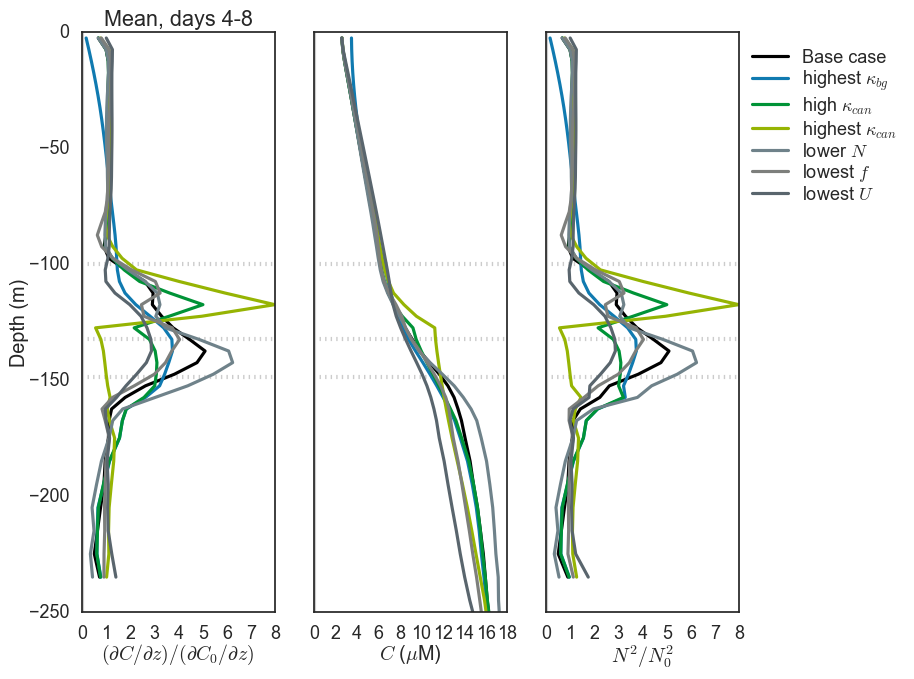

In [31]:
key0 = 'dTrdz_tt00'
sns.set_context('talk')
f = plt.figure(figsize = (8.48,7.48)) # 190mm = 7.48 in, 115mm = 4.5in

gs = gspec.GridSpec(1, 3, width_ratios=[1,1,1],wspace=0.2)
gs0 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,0],hspace=0.1)
gs1 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,1],hspace=0.1)
gs2 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,2],hspace=0.1)

ax0 = plt.subplot(gs0[0])

ax2 = plt.subplot(gs1[0],yticks=[])

ax4 = plt.subplot(gs2[0],yticks=[])

t=4 # days

#%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax0.axvline(0,color='0.8',linestyle='-')
ax0.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax0.plot(rec.meandTrprof[:48]/rec.dTrprof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax0.set_xlabel('$(\partial C/\partial z) / (\partial C_0/\partial z)$ ',labelpad=0.0)
ax0.set_ylabel('Depth (m)',labelpad=0.0)

ax0.set_title('Mean, days 4-8')
ax0.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax2.axvline(0,color='0.8',linestyle='-')
ax2.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax2.plot(rec.meanCprof[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax2.set_xlabel('$C$ ($\mu$M)',labelpad=0.0)

ax2.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% N  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax4.axvline(0,color='0.8',linestyle='-')
ax4.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind,lab in zip(select_rec,labels):
    rec=records[ind]
    ax4.plot(rec.meanN2prof[:48]/rec.N2prof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2],label=lab)
    
ax4.set_xlabel('$N^2/N^2_0$',labelpad=0.0)
ax4.legend(bbox_to_anchor=(1.9,1.0),ncol=1,labelspacing=0.1,columnspacing=0.1,frameon=False)
ax4.set_ylim(-250,0)

    


#plt.savefig('fig_Tr_N_profiles.eps',format='eps',bbox_inches='tight')


(-250, 0)

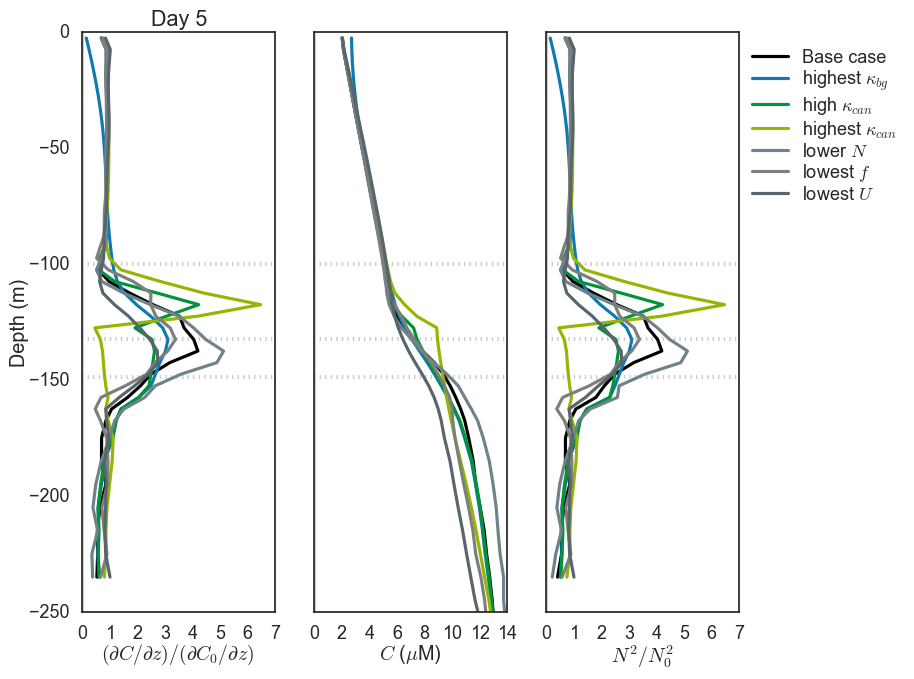

In [32]:
key0 = 'dTrdz_tt00'
sns.set_context('talk')
f = plt.figure(figsize = (8.48,7.48)) # 190mm = 7.48 in, 115mm = 4.5in

gs = gspec.GridSpec(1, 3, width_ratios=[1,1,1],wspace=0.2)
gs0 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,0],hspace=0.1)
gs1 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,1],hspace=0.1)
gs2 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,2],hspace=0.1)

ax0 = plt.subplot(gs0[0])

ax2 = plt.subplot(gs1[0],yticks=[])

ax4 = plt.subplot(gs2[0],yticks=[])

t=4 # days

#%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax0.axvline(0,color='0.8',linestyle='-')
ax0.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax0.plot(rec.dTrprof5[:48]/rec.dTrprof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax0.set_xlabel('$(\partial C/\partial z) / (\partial C_0/\partial z)$ ',labelpad=0.0)
ax0.set_ylabel('Depth (m)',labelpad=0.0)
ax0.set_title('Day 5')
ax0.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax2.axvline(0,color='0.8',linestyle='-')
ax2.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax2.plot(rec.Cprof5[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax2.set_xlabel('$C$ ($\mu$M)',labelpad=0.0)

ax2.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% N  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax4.axvline(0,color='0.8',linestyle='-')
ax4.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind,lab in zip(select_rec,labels):
    rec=records[ind]
    ax4.plot(rec.N2prof5[:48]/rec.N2prof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2],label=lab)
    
ax4.set_xlabel('$N^2/N^2_0$',labelpad=0.0)
ax4.legend(bbox_to_anchor=(1.9,1.0),ncol=1,labelspacing=0.1,columnspacing=0.1,frameon=False)
ax4.set_ylim(-250,0)

    


#plt.savefig('fig_Tr_N_profiles.eps',format='eps',bbox_inches='tight')


(-250, 0)

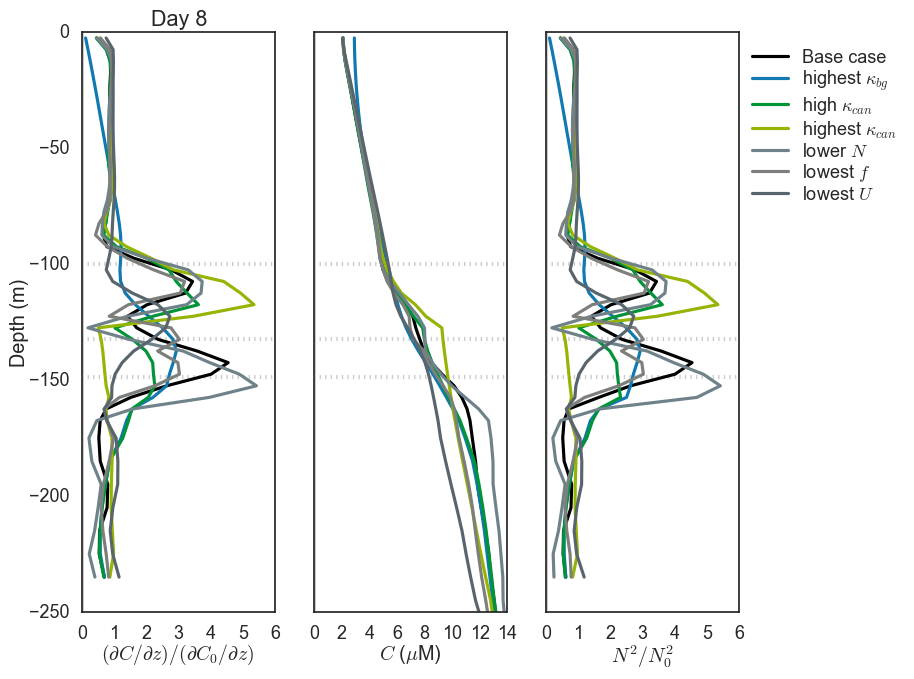

In [33]:
key0 = 'dTrdz_tt00'
sns.set_context('talk')
f = plt.figure(figsize = (8.48,7.48)) # 190mm = 7.48 in, 115mm = 4.5in

gs = gspec.GridSpec(1, 3, width_ratios=[1,1,1],wspace=0.2)
gs0 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,0],hspace=0.1)
gs1 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,1],hspace=0.1)
gs2 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,2],hspace=0.1)

ax0 = plt.subplot(gs0[0])

ax2 = plt.subplot(gs1[0],yticks=[])

ax4 = plt.subplot(gs2[0],yticks=[])

t=4 # days

#%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax0.axvline(0,color='0.8',linestyle='-')
ax0.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax0.plot(rec.dTrprof8[:48]/rec.dTrprof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax0.set_xlabel('$(\partial C/\partial z) / (\partial C_0/\partial z)$ ',labelpad=0.0)
ax0.set_ylabel('Depth (m)',labelpad=0.0)

ax0.set_title('Day 8')
ax0.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax2.axvline(0,color='0.8',linestyle='-')
ax2.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax2.plot(rec.Cprof8[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax2.set_xlabel('$C$ ($\mu$M)',labelpad=0.0)

ax2.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% N  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax4.axvline(0,color='0.8',linestyle='-')
ax4.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind,lab in zip(select_rec,labels):
    rec=records[ind]
    ax4.plot(rec.N2prof8[:48]/rec.N2prof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2],label=lab)
    
ax4.set_xlabel('$N^2/N^2_0$',labelpad=0.0)
ax4.legend(bbox_to_anchor=(1.9,1.0),ncol=1,labelspacing=0.1,columnspacing=0.1,frameon=False)
ax4.set_ylim(-250,0)

    


#plt.savefig('fig_Tr_N_profiles.eps',format='eps',bbox_inches='tight')
